In [45]:
import xarray as xr
path = '/Users/ls/Downloads/3d917b4bfd317601600e45aef24cb41d.grib'
df1 = xr.open_dataset(path)

In [46]:
u10 = df1.u10.data[:50,:50,:50] 
v10 = df1.v10.data[:50,:50,:50] 
time = df1.time.data[:50]  
latitudes = df1.latitude.data[:50]
longitudes = df1.longitude.data[:50]


In [47]:
u10.shape

(50, 50, 50)

In [48]:
import numpy as np

nodes = np.array([[lat, lon] for lat in latitudes for lon in longitudes])
# latitudes = latitudes[:, :100]
# longitudes = longitude[:, :100]
# u10 = u10[:, :100]  # Subset the first 100 nodes, for example
# v10 = v10[:, :100]
# nodes = nodes[:100]
# time = time[:100]



u = u10.reshape(len(time), len(latitudes) * len(longitudes))
v = v10.reshape(len(time), len(latitudes) * len(longitudes))


In [49]:
import numpy as np
from datetime import datetime
from scipy.interpolate import griddata

from halem import BaseRoadmap, HALEM_space, HALEM_time, plot_timeseries, HALEM_cost,HALEM_co2

import matplotlib.pyplot as plt

In [5]:
class CustomRoadmap(BaseRoadmap):
    def load(self):
        return {
            "time": time.astype(np.float64),  # Convert time to float if necessary
            "nodes": nodes,
            "u": u,
            "v": v,
            "water_depth": np.full(u.shape, 100)  # Example: fill with a constant depth if not available
        }


In [6]:
roadmap = CustomRoadmap(
    number_of_neighbor_layers=2,  # Define how many layers of neighbors you want to consider
    vship=np.array([[1, 4, 8], [1, 5, 10]]),  # Example ship velocities
    WD_min=np.array([8, 7]),  # Example minimum water depth
    WVPI=np.array([4000, 10000]),  # Example weight of the vessel
    WWL=40,  # Example width over water line
    LWL=80,  # Example length over water line
    ukc=1.5,  # Example under keel clearance
    blend=1,
    nl=(3, 2.5),
    dx_min=0.1,
    repeat=False  # Set to True if your data repeats periodically (like tidal data)
)

In [7]:
from halem import HALEM_time

start = (90, -180)  # Starting point (longitude, latitude)
stop = (-90, 0)   # Ending point (longitude, latitude)
t0 = "2024-08-01 00:00:00"  # Starting time
vmax = np.array([[1, 4, 8], [1, 5, 10]])  # Example ship speeds

path, time, dist = HALEM_time(start, stop, t0, vmax, roadmap)


AttributeError: 'CustomRoadmap' object has no attribute 'weight_time'

In [8]:
import numpy as np
from halem import BaseRoadmap

class CustomRoadmap(BaseRoadmap):
    def __init__(
        self,
        u10,  # The u10 wind component
        v10,  # The v10 wind component
        time,  # Time variable from your dataset
        nodes,  # Nodes (latitude and longitude grid points)
        number_of_neighbor_layers=2,  # You can adjust this based on your grid resolution
        vship=np.array([[1, 4, 8], [1, 5, 10]]),
        WD_min=np.array([8, 7]),
        WVPI=np.array([4000, 10000]),
        WWL=40,
        LWL=80,
        ukc=1.5,
        nl=(3, 2.5),
        blend=1,
        nodes_index=None,
        *args,
        **kwargs
    ):
        self.u10 = u10
        self.v10 = v10
        self.time = time
        self.nodes = nodes
        super().__init__(
            number_of_neighbor_layers=number_of_neighbor_layers,
            vship=vship,
            WD_min=WD_min,
            WVPI=WVPI,
            WWL=WWL,
            LWL=LWL,
            ukc=ukc,
            nl=nl,
            blend=blend,
            nodes_index=nodes_index,
            *args,
            **kwargs
        )

    def load(self):
        """This method loads the necessary data for the roadmap.
        It returns a dictionary with keys corresponding to time, nodes, u, v, and water depth.
        """
        # Here we assume that water depth (WD) is a constant or can be derived, adjust if needed.
        WD = np.full(self.u10.shape, 50)  # Assuming a constant water depth of 50m.

        return {
            "time": self.time,
            "nodes": self.nodes,
            "u": self.u10,
            "v": self.v10,
            "water_depth": WD,
        }


In [20]:
# Assuming you have loaded your u10, v10, time, and nodes data correctly
import scipy.spatial
# Create an instance of CustomRoadmap
roadmap = CustomRoadmap(
    u10=u10,  # Replace with your u10 data array
    v10=v10,  # Replace with your v10 data array
    time=time,  # Replace with your time array
    nodes=nodes,
    dx_min=0.1   # Replace with your nodes (latitude, longitude) array
)

# Parse the data to prepare for optimization
roadmap.parse()

# Example of finding the optimal route using the HALEM_time function for the fastest route
start = (longitude_start, latitude_start)  # Replace with start coordinates
stop = (longitude_stop, latitude_stop)  # Replace with stop coordinates
t0 = "2023-08-10 00:00:00"  # Replace with the start time for the journey
vmax = np.array([[2, 5, 10]])  # Replace with your vessel's maximum speed array

optimal_path, optimal_time, distance = HALEM_time(start, stop, t0, vmax, roadmap)



Loading hydrodynamic data...


AssertionError: 

In [50]:
import numpy as np
from halem import BaseRoadmap

class CustomRoadmap(BaseRoadmap):
    def __init__(
        self,
        u10,  # The u10 wind component
        v10,  # The v10 wind component
        time,  # Time variable from your dataset
        nodes,  # Nodes (latitude and longitude grid points)
        number_of_neighbor_layers=1,  # You can adjust this based on your grid resolution
        vship=np.array([[1, 4, 8], [1, 5, 10]]),
        WD_min=np.array([8, 7]),
        WVPI=np.array([4000, 10000]),
        WWL=40,
        LWL=80,
        ukc=1.5,
        nl=(3, 2.5),
        blend=1,
        nodes_index=None,
        *args,
        **kwargs
    ):
        # Convert time to numeric format
        self.time = time.astype('datetime64[ns]').astype(np.float64)
        self.u10 = u10
        self.v10 = v10
        self.nodes = nodes
        super().__init__(
            number_of_neighbor_layers=number_of_neighbor_layers,
            vship=vship,
            WD_min=WD_min,
            WVPI=WVPI,
            WWL=WWL,
            LWL=LWL,
            ukc=ukc,
            nl=nl,
            blend=blend,
            nodes_index=nodes_index,
            *args,
            **kwargs
        )

    def load(self):
        """This method loads the necessary data for the roadmap.
        It returns a dictionary with keys corresponding to time, nodes, u, v, and water depth.
        """
        # Assuming a constant water depth (WD)
        WD = np.full(self.u10.shape, 50)  # Adjust water depth as needed

        return {
            "time": self.time,
            "nodes": self.nodes,
            "u": self.u10,
            "v": self.v10,
            "water_depth": WD,
        }
    def parse(self):
        print("Loading hydrodynamic data...")
        self.load_hydrodynamic()
        print("Hydrodynamic data loaded.")

        # 'Calculate nodes and flow conditions in nodes'
        if self.nodes_index is None:
            print("Reducing nodes...")
            self.nodes_index, self.LS = self.get_nodes()
            print("Node reduction completed.")
        else:
            self.nodes_index = self.nodes_index
            self.LS = None
            print("Using precomputed nodes index.")
    
        nodes = self.nodes[self.nodes_index]
        u = np.asarray(np.transpose(self.u))[self.nodes_index]
        v = np.asarray(np.transpose(self.v))[self.nodes_index]
        WD = np.asarray(np.transpose(self.WD))[self.nodes_index]
    
        print("Nodes, u, v, WD loaded for land.")
        self.nodes, self.u, self.v, self.WD = self.nodes_on_land(nodes, u, v, WD)
        self.tria = scipy.spatial.Delaunay(self.nodes)
        self.mask = np.full(self.u.shape, False)
        self.mask[self.WD < self.WD_min.max() + self.ukc] = True
        print("Mask applied.")
    
        # 'Calculate edges'
        print("Calculating edges...")
        graph0 = Graph()
        for from_node in range(len(self.nodes)):
            if from_node % 100 == 0:  # Print progress every 100 nodes
                print(f"Processed {from_node} nodes out of {len(self.nodes)}")
            to_nodes = functions.find_neighbors2(
                from_node, self.tria, self.number_of_neighbor_layers
            )
            for to_node in to_nodes:
                L = functions.haversine(self.nodes[from_node], self.nodes[int(to_node)])
                graph0.add_edge(from_node, int(to_node), L)
        self.graph = Graph()
        vship1 = self.vship[0]
        for edge in graph0.weights:
            for i in range(len(vship1)):
                for j in range(len(vship1)):
                    from_node = edge[0]
                    to_node = edge[1]
                    self.graph.add_edge((from_node, i), (to_node, j), 1)

        print("Edge calculation completed.")
        # 'Calculate Weights'
        calc_weights = self.calc_weights_time
        self.weight_space = []
        self.weight_time = []
        self.weight_cost = []
        self.weight_co2 = []

        for vv in range(len(self.vship)):
            graph_time = Graph()
            graph_space = Graph()
            graph_cost = Graph()
            graph_co2 = Graph()
            vship = self.vship[vv]
            WD_min = self.WD_min[vv]
            WVPI = self.WVPI[vv]
            for edge in graph0.weights:
                for i in range(len(vship)):
                    for j in range(len(vship)):
                        from_node = edge[0]
                        to_node = edge[1]

                        L, W, euros, co2 = calc_weights(
                            edge,
                            i,
                            j,
                            vship,
                            WD_min,
                            WVPI,
                            self,
                            self.compute_cost,
                            self.compute_co2,
                            self.number_of_neighbor_layers,
                        )

                        graph_time.add_edge((from_node, i), (to_node, j), W)
                        graph_space.add_edge((from_node, i), (to_node, j), L)
                        graph_cost.add_edge((from_node, i), (to_node, j), euros)
                        graph_co2.add_edge((from_node, i), (to_node, j), co2)

            if "space" in self.optimization_type:
                self.weight_space.append(graph_space)
            if "time" in self.optimization_type:
                self.weight_time.append(graph_time)
            if "cost" in self.optimization_type:
                self.weight_cost.append(graph_cost)
            if "co2" in self.optimization_type:
                self.weight_co2.append(graph_co2)

    def calc_weights_time(
        self,
        edge,
        i,
        j,
        vship,
        WD_min,
        WVPI,
        self_f,
        compute_cost,
        compute_co2,
        number_of_neighbor_layers,
    ):
        """Function that retruns the weight of an arc"""
        from_node = edge[0]
        W = (
            functions.costfunction_timeseries(
                edge,
                vship[j],
                WD_min,
                self_f,
                WVPI,
                number_of_neighbor_layers,
                self_f.tria,
            )
            + self_f.t
        )
        W = self.fifo_maker(W, self_f.mask[from_node]) - self_f.t

        L = functions.costfunction_spaceseries(
            edge, vship[j], WD_min, self_f, WVPI, number_of_neighbor_layers, self_f.tria
        )
        L = L + np.arange(len(L)) * (1 / len(L))
        L = self.fifo_maker(L, self_f.mask[from_node]) - np.arange(len(L)) * (
            1 / len(L)
        )
        euros = compute_cost(W, vship[j])
        co2 = compute_co2(W, vship[j])

        return L, W, euros, co2

    @staticmethod
    def fifo_maker(y, N1):
        """Makes a FIFO time series from a Non-FIFO time series
        y:  Time series
        N1: Mask file of the time series
        """
        arg = np.squeeze(argrelextrema(y, np.less))
        if arg.shape == ():
            arg = np.array([arg])
        else:
            None
        y_FIFO = 1 * y
        for a in arg:
            loc = np.argwhere(y[: a + 1] <= y[a])[-2:]
            if loc.shape == (2, 1):
                if True in N1[int(loc[0]) : int(loc[1])]:
                    None
                else:
                    y_FIFO[int(loc[0]) : int(loc[1])] = y[a]
        return y_FIFO

        


In [51]:
# Create an instance of CustomRoadmap
roadmap = CustomRoadmap(
    u10=u,  # Replace with your u10 data array
    v10=v,  # Replace with your v10 data array
    time=time,  # Replace with your time array
    nodes=nodes,
    dx_min=0.1 # Replace with your nodes (latitude, longitude) array
)

# Parse the data to prepare for optimization
class Graph:
    """class that contains the nodes, arcs, and weights for the time-dependent,
    directional, weighted, and Non-FIFO graph of the route optimization problem.
    This class is used multiple times in the halem.mesh_maker.GraphFlowModel()
    function"""

    def __init__(self):
        """
        self.edges is a dict of all possible next nodes
        e.g. {'X': ['A', 'B', 'C', 'E'], ...}
        self.weights has all the weights between two nodes,
        with the two nodes as a tuple as the key
        e.g. {('X', 'A'): 7, ('X', 'B'): 2, ...}
        """
        self.edges = defaultdict(list)
        self.weights = {}

    def add_edge(self, from_node, to_node, weight):
        # Note: assumes edges are directional
        self.edges[from_node].append(to_node)
        self.weights[(from_node, to_node)] = weight



In [52]:
from abc import ABC, abstractmethod
from collections import defaultdict

import numpy as np
import scipy.spatial
from numpy import ma
from scipy.signal import argrelextrema

import halem.functions as functions

roadmap.parse()

Loading hydrodynamic data...
Hydrodynamic data loaded.
Reducing nodes...
Node reduction completed.
Nodes, u, v, WD loaded for land.
Mask applied.
Calculating edges...
Processed 0 nodes out of 2500
Processed 100 nodes out of 2500
Processed 200 nodes out of 2500
Processed 300 nodes out of 2500
Processed 400 nodes out of 2500
Processed 500 nodes out of 2500
Processed 600 nodes out of 2500
Processed 700 nodes out of 2500
Processed 800 nodes out of 2500
Processed 900 nodes out of 2500
Processed 1000 nodes out of 2500
Processed 1100 nodes out of 2500
Processed 1200 nodes out of 2500
Processed 1300 nodes out of 2500
Processed 1400 nodes out of 2500
Processed 1500 nodes out of 2500
Processed 1600 nodes out of 2500
Processed 1700 nodes out of 2500
Processed 1800 nodes out of 2500
Processed 1900 nodes out of 2500
Processed 2000 nodes out of 2500
Processed 2100 nodes out of 2500
Processed 2200 nodes out of 2500
Processed 2300 nodes out of 2500
Processed 2400 nodes out of 2500
Edge calculation com

/var/folders/9p/34kjp0md5tv5sz77mfqf7y440000gn/T/ipykernel_2215/3002667132.py:211: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if True in N1[int(loc[0]) : int(loc[1])]:
/var/folders/9p/34kjp0md5tv5sz77mfqf7y440000gn/T/ipykernel_2215/3002667132.py:214: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_FIFO[int(loc[0]) : int(loc[1])] = y[a]


In [53]:
t0 = "01/01/2024 00:00:00"  # Departure time

start = (90, -90)
stop = (0, 90)
v_max = 7


path_t, time_t, dist_t = HALEM_time(start, stop, t0, v_max, roadmap)
path_s, time_s, dist_s = HALEM_space(start, stop, t0, v_max, roadmap)
path_c, time_c, dist_c = HALEM_cost(start, stop, t0, v_max, roadmap)
path_p, time_p, dist_p = HALEM_co2(start, stop, t0, v_max, roadmap)

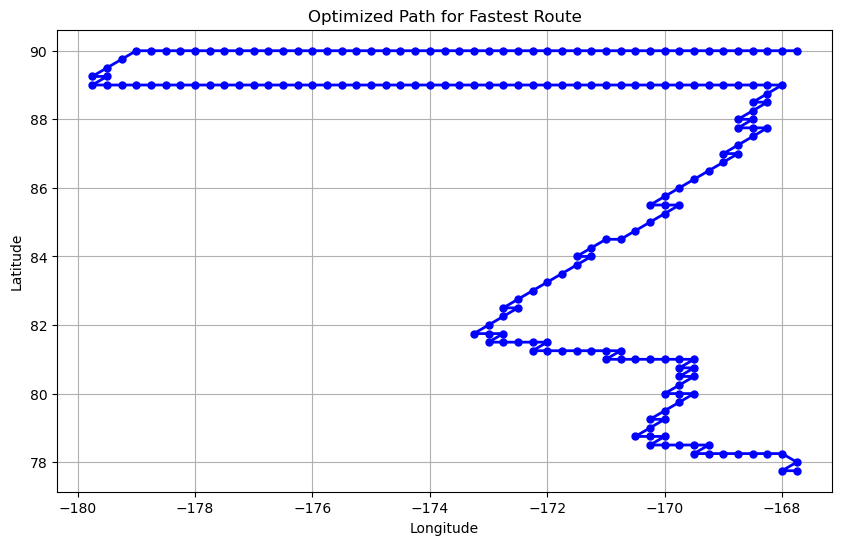

In [54]:
import matplotlib.pyplot as plt
import numpy as np

def plot_path(path, title="Optimized Path", color='blue'):
    """
    Function to plot the optimized path.
    
    Parameters:
    - path: Numpy array containing the latitude and longitude coordinates of the path.
    - title: Title of the plot.
    - color: Color of the path.
    """
    latitudes = path[:, 1]
    longitudes = path[:, 0]
    
    plt.figure(figsize=(10, 6))
    plt.plot(longitudes, latitudes, color=color, marker='o', linestyle='-', linewidth=2, markersize=5)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

# Example usage of the plot_path function
# Assuming `optimized_path` is the result from your HALEM function
# optimized_path = np.array(...)  # Replace this with your actual path data
# plot_path(optimized_path)
plot_path(path_c, title="Optimized Path for Fastest Route")

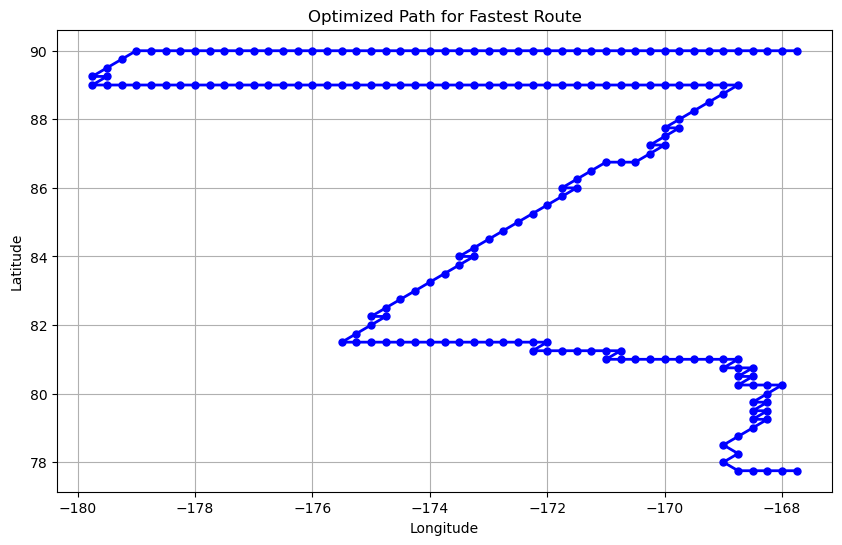

In [55]:
plot_path(path_p, title="Optimized Path for Fastest Route")

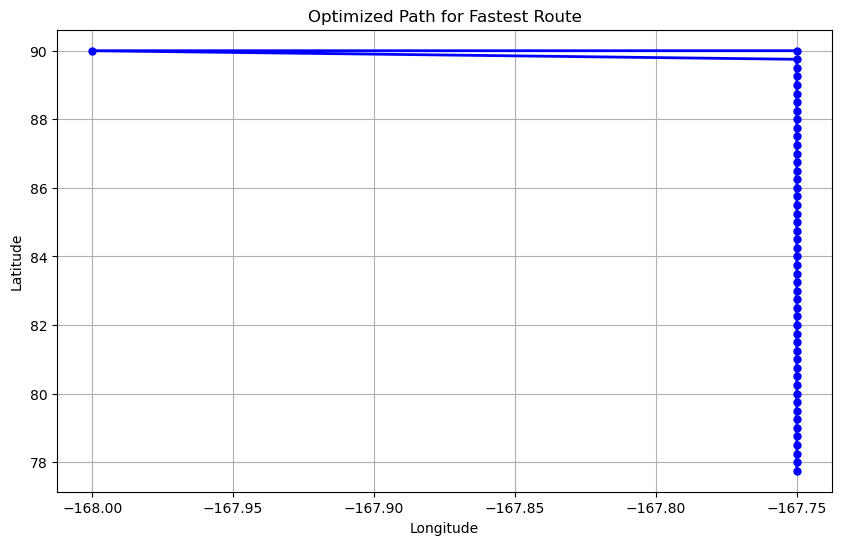

In [56]:
plot_path(path_s, title="Optimized Path for Fastest Route")

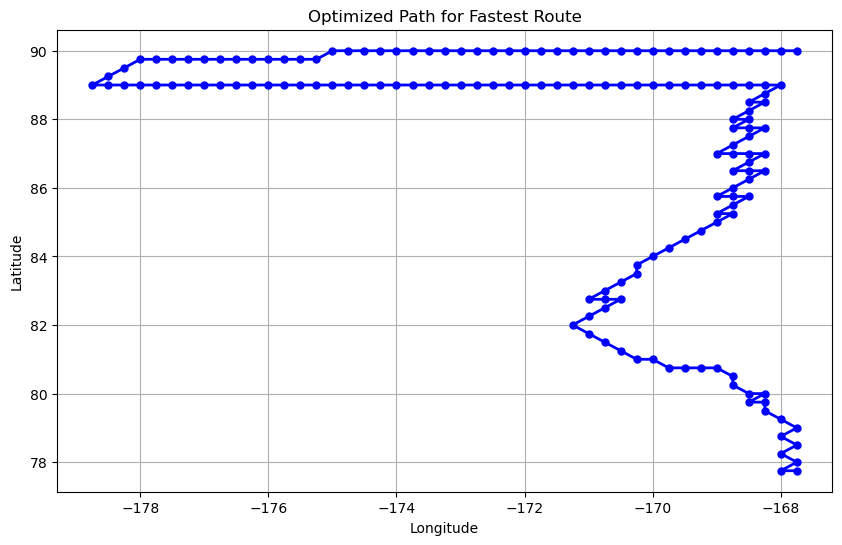

In [57]:
plot_path(path_t, title="Optimized Path for Fastest Route")

In [58]:
latitudes

array([90.  , 89.75, 89.5 , 89.25, 89.  , 88.75, 88.5 , 88.25, 88.  ,
       87.75, 87.5 , 87.25, 87.  , 86.75, 86.5 , 86.25, 86.  , 85.75,
       85.5 , 85.25, 85.  , 84.75, 84.5 , 84.25, 84.  , 83.75, 83.5 ,
       83.25, 83.  , 82.75, 82.5 , 82.25, 82.  , 81.75, 81.5 , 81.25,
       81.  , 80.75, 80.5 , 80.25, 80.  , 79.75, 79.5 , 79.25, 79.  ,
       78.75, 78.5 , 78.25, 78.  , 77.75])

In [59]:
longitudes

array([-180.  , -179.75, -179.5 , -179.25, -179.  , -178.75, -178.5 ,
       -178.25, -178.  , -177.75, -177.5 , -177.25, -177.  , -176.75,
       -176.5 , -176.25, -176.  , -175.75, -175.5 , -175.25, -175.  ,
       -174.75, -174.5 , -174.25, -174.  , -173.75, -173.5 , -173.25,
       -173.  , -172.75, -172.5 , -172.25, -172.  , -171.75, -171.5 ,
       -171.25, -171.  , -170.75, -170.5 , -170.25, -170.  , -169.75,
       -169.5 , -169.25, -169.  , -168.75, -168.5 , -168.25, -168.  ,
       -167.75])